In [1]:
import os
import h5py
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sys import stdout
from datetime import datetime
import neptune.new as neptune
from neptune.new.integrations.tensorflow_keras import NeptuneCallback
from astropy.io import fits

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Cropping2D, ZeroPadding2D
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import Input, Flatten, Dense, Reshape
import tensorflow_probability as tfp
from tensorflow_probability import layers as tfpl
from tensorflow_probability import distributions as tfd
from tensorflow.nn import leaky_relu
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau

In [3]:
LATENT_DIM = 128
BASE_DEPTH = 8
IMAGE_SHAPE = (5, 127, 127)
EPOCHS = 200
CHECKPOINTS_TO_SAVE = 4
KL_WEIGHT = 1e-5
# Good value: 1e-6

In [4]:
gpus = tf.config.list_physical_devices('GPU');
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit = 20000)]);
        logical_gpus = tf.config.experimental.list_logical_devices('GPU');
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [5]:
now = datetime.now()

DATASET_NAME = "HSC_v6_small"
MODEL_TYPE = "VAE"
MODEL_VERSION = "v1.0"
MODEL_SUBVERSION = "v1.0.20221118_14_03_25"

model_id = '_'.join([DATASET_NAME, MODEL_TYPE, MODEL_VERSION])

model_path = os.path.join('/models', model_id, MODEL_SUBVERSION, 'model')

weights_path = model_path + '/weights.h5'

In [6]:
hf_train = h5py.File('/data/HSC/HSC_v6/step2A/127x127/5x127x127_training_small.hdf5', 'r')
hf_test = h5py.File('/data/HSC/HSC_v6/step2A/127x127/5x127x127_testing_small.hdf5', 'r')
hf_validation = h5py.File('/data/HSC/HSC_v6/step2A/127x127/5x127x127_validation_small.hdf5', 'r')
x_train = np.asarray(hf_train['image'][0:])
x_test = np.asarray(hf_test['image'][0:])
x_validation = np.asarray(hf_validation['image'][0:])
max_value = 4.16
x_train = np.true_divide(x_train, max_value)
x_test = np.true_divide(x_test, max_value)
x_validation = np.true_divide(x_validation, max_value)
y_train = np.asarray(hf_train['specz_redshift'][0:])[..., None]
y_test = np.asarray(hf_test['specz_redshift'][0:])[..., None]
y_validation = np.asarray(hf_validation['specz_redshift'][0:])[..., None]
# object_id_train = np.asarray(hf_train['object_id'][0:])
# object_id = np.asarray(hf_test['object_id'][0:])
# object_id_validation = np.asarray(hf_validation['object_id'][0:])
hf_train.close()
hf_test.close()
hf_validation.close()

In [7]:
prior = tfd.Independent(tfd.Normal(loc=tf.zeros(LATENT_DIM), scale = 0.1), reinterpreted_batch_ndims = 1)

class VAE(Model):
    def __init__(self):
        super(VAE, self).__init__()
        
        images = Input(shape = IMAGE_SHAPE)
        x = Conv2D(BASE_DEPTH, 3, strides = 2, activation = leaky_relu,
                   padding = 'same', data_format = 'channels_first')(images)
        x = Conv2D(BASE_DEPTH, 3, strides = 2, activation = leaky_relu,
                   padding = 'same', data_format = 'channels_first')(x)
        x = Flatten()(x)
        x = Dense(tfpl.MultivariateNormalTriL.params_size(LATENT_DIM), activation = None)(x)
        z = tfpl.MultivariateNormalTriL(LATENT_DIM,
                  activity_regularizer=tfpl.KLDivergenceRegularizer(prior, weight = KL_WEIGHT))(x)
        self.encoder = Model(images, z, name = 'encoder')

        latents = Input(shape = LATENT_DIM)
        x = Dense(8 * LATENT_DIM * 32 * 32, activation = None)(latents)
        x = Reshape((8 * LATENT_DIM, 32, 32))(x)
        x = Conv2DTranspose(BASE_DEPTH, 3, strides = 2, activation = leaky_relu,
                            padding = 'same', data_format = 'channels_first')(x)
        x = Conv2DTranspose(BASE_DEPTH, 3, strides = 2, activation = leaky_relu,
                            padding = 'same', data_format = 'channels_first')(x)
        x = Conv2DTranspose(BASE_DEPTH, 3, strides = 1, activation = leaky_relu,
                            padding = 'same', data_format = 'channels_first')(x)
        x = Conv2D(IMAGE_SHAPE[0], 3, strides = 1, activation = None, 
                   padding = 'same', data_format = 'channels_first')(x)
        outputs = Cropping2D(cropping=((0, 1), (0, 1)), data_format = 'channels_first')(x)
        self.decoder = Model(latents, outputs, name = 'decoder')

    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def summary(self):
        print(self.encoder.summary())
        print(self.decoder.summary())

In [8]:
model = VAE()
model.compile(optimizer = 'adam', loss = 'mse')
model.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5, 127, 127)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 8, 64, 64)         368       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 32, 32)         584       
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 8384)              68690112  
_________________________________________________________________
multivariate_normal_tri_l (M multiple                  0         
Total params: 68,691,064
Trainable params: 68,691,064
Non-trainable params: 0
_______________________________________________

In [9]:
run = neptune.init(
    name = MODEL_SUBVERSION,
    project = "astro-data-lab/VAE",
    api_token = "eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxOGFlZGMxOC04MWU5LTQ2NDctYjlhZS05NGE2NGQ0NmIzMmEifQ==",
)  # your credentials

# logs_callback = TensorBoard(log_dir = logs_path)

LR_callback = ReduceLROnPlateau()

# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logs_path, histogram_freq = 1)

neptune_callback = NeptuneCallback(run = run)

https://app.neptune.ai/astro-data-lab/VAE/e/VAE-63
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [10]:
history = model.fit(x = x_train, y = x_train, epochs = EPOCHS, callbacks = [LR_callback], validation_data = (x_validation, x_validation), verbose = 1)

Epoch 1/200
313/313 [==============================] - 425s 31ms/step - loss: 0.2242 - val_loss: 0.1629
Epoch 2/200
313/313 [==============================] - 9s 29ms/step - loss: 0.1749 - val_loss: 0.1496
Epoch 3/200
313/313 [==============================] - 9s 29ms/step - loss: 0.1518 - val_loss: 0.1431
Epoch 4/200
313/313 [==============================] - 9s 29ms/step - loss: 0.1490 - val_loss: 0.2378
Epoch 5/200
313/313 [==============================] - 9s 29ms/step - loss: 0.1584 - val_loss: 0.1607
Epoch 6/200
313/313 [==============================] - 9s 29ms/step - loss: 0.1492 - val_loss: 0.1502
Epoch 7/200
313/313 [==============================] - 9s 29ms/step - loss: 0.1426 - val_loss: 0.1415
Epoch 8/200
313/313 [==============================] - 9s 30ms/step - loss: 0.1721 - val_loss: 0.1461
Epoch 9/200
313/313 [==============================] - 9s 29ms/step - loss: 0.1408 - val_loss: 0.1385
Epoch 10/200
313/313 [==============================] - 9s 29ms/step - loss: 0.1

313/313 [==============================] - 9s 29ms/step - loss: 0.0991 - val_loss: 0.1202
Epoch 81/200
313/313 [==============================] - 9s 30ms/step - loss: 0.0943 - val_loss: 0.1186
Epoch 82/200
313/313 [==============================] - 9s 29ms/step - loss: 0.0963 - val_loss: 0.1189
Epoch 83/200
313/313 [==============================] - 9s 30ms/step - loss: 0.0971 - val_loss: 0.1195
Epoch 84/200
313/313 [==============================] - 9s 29ms/step - loss: 0.0968 - val_loss: 0.1198
Epoch 85/200
313/313 [==============================] - 9s 29ms/step - loss: 0.0953 - val_loss: 0.1176
Epoch 86/200
313/313 [==============================] - 9s 29ms/step - loss: 0.0976 - val_loss: 0.1187
Epoch 87/200
313/313 [==============================] - 9s 29ms/step - loss: 0.0987 - val_loss: 0.1216
Epoch 88/200
313/313 [==============================] - 9s 29ms/step - loss: 0.0977 - val_loss: 0.1201
Epoch 89/200
313/313 [==============================] - 9s 29ms/step - loss: 0.0955 - 

313/313 [==============================] - 9s 29ms/step - loss: 0.0999 - val_loss: 0.1198
Epoch 160/200
313/313 [==============================] - 9s 29ms/step - loss: 0.0976 - val_loss: 0.1180
Epoch 161/200
313/313 [==============================] - 9s 29ms/step - loss: 0.0964 - val_loss: 0.1205
Epoch 162/200
313/313 [==============================] - 9s 29ms/step - loss: 0.0971 - val_loss: 0.1214
Epoch 163/200
313/313 [==============================] - 9s 29ms/step - loss: 0.0974 - val_loss: 0.1184
Epoch 164/200
313/313 [==============================] - 9s 29ms/step - loss: 0.0972 - val_loss: 0.1210
Epoch 165/200
313/313 [==============================] - 9s 29ms/step - loss: 0.0993 - val_loss: 0.1172
Epoch 166/200
313/313 [==============================] - 9s 29ms/step - loss: 0.0971 - val_loss: 0.1191
Epoch 167/200
313/313 [==============================] - 9s 30ms/step - loss: 0.0940 - val_loss: 0.1209
Epoch 168/200
313/313 [==============================] - 9s 29ms/step - loss: 

In [11]:
def generate_example_galaxies(num_to_generate = 10):
    z = prior.sample(num_to_generate)
    xhat = model.decoder(z)
    fig, axes = plt.subplots(nrows = num_to_generate, ncols = 5, figsize = (4 * 5, 4 * num_to_generate))
    for i in range(num_to_generate):
        for j in range(0,5):
            axes[i][j].imshow(xhat[i][j], cmap = 'afmhot')
            axes[i][j].set_title(f'Generated image {i} band {j}')

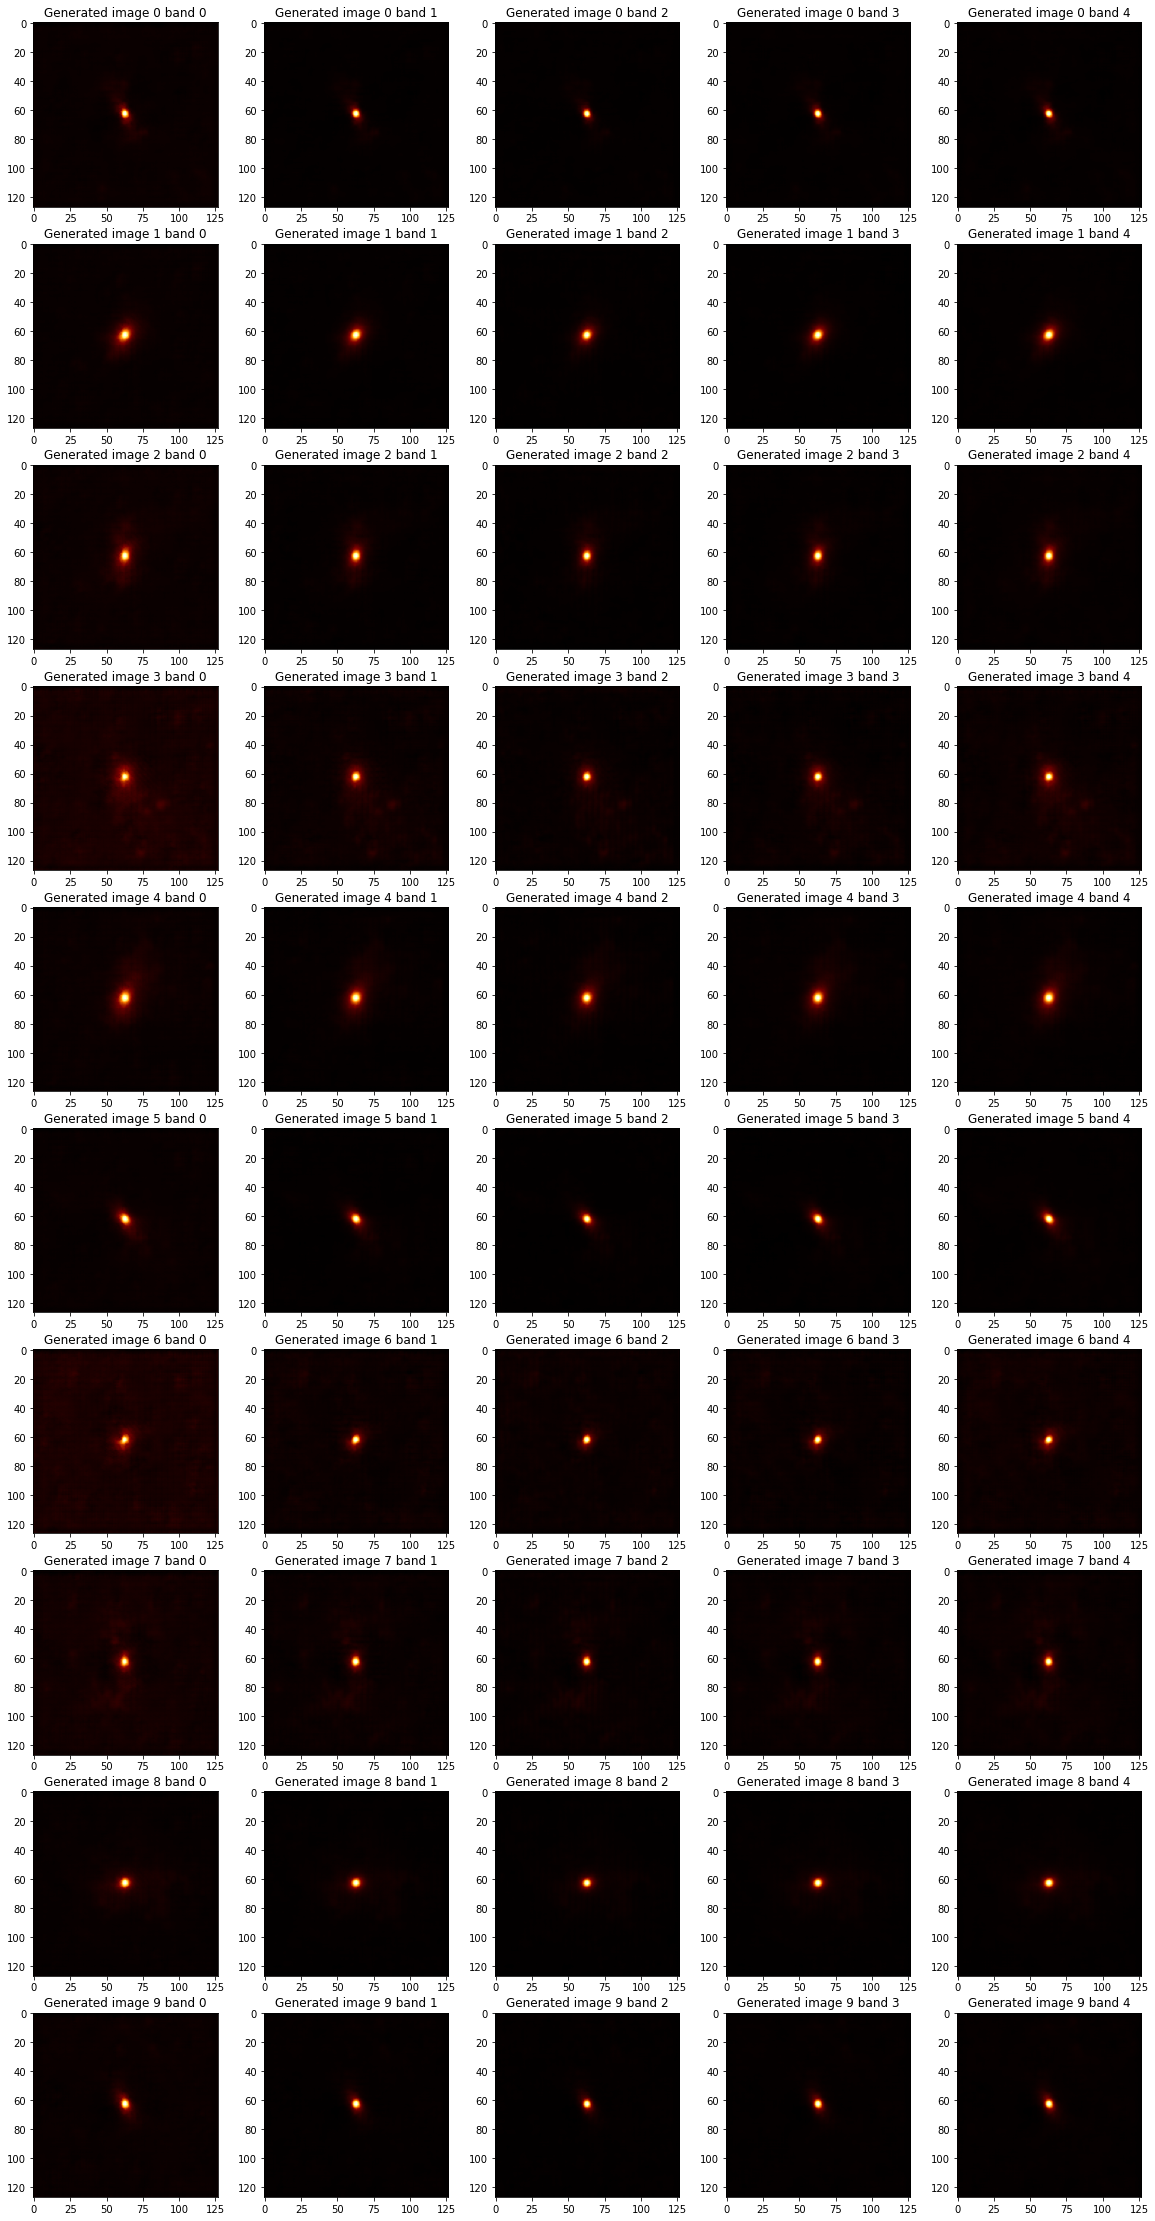

In [12]:
generate_example_galaxies(10)

In [13]:
image_list_g = sorted(os.listdir("/mnt/data/HSC/HSC_v6/step1/g_band"))
image_list_r = sorted(os.listdir("/mnt/data/HSC/HSC_v6/step1/r_band"))
image_list_i = sorted(os.listdir("/mnt/data/HSC/HSC_v6/step1/i_band"))
image_list_z = sorted(os.listdir("/mnt/data/HSC/HSC_v6/step1/z_band"))
image_list_y = sorted(os.listdir("/mnt/data/HSC/HSC_v6/step1/y_band"))

photozdata = pd.read_csv('/mnt/data/HSC/HSC_v6/HSC_v6.csv')
photozdata.describe()

b = np.argsort(photozdata['object_id'])
sorted_photozdata = photozdata.iloc[b][:]
photozdata = sorted_photozdata

hf = h5py.File('/mnt/data/HSC/HSC_v6/step3/127x127_with_vae_loss.hdf5', 'a')

In [14]:
count = 0
size = len(image_list_g)

oid_array = np.array([])
specz_array = np.array([])
vae_loss_array = np.array([])

for i in range(size):
    
    stdout.write("\rChecking %d samples of " % (i + 1) + str(size))
    
    object_id = image_list_g[i][0:17]

    five_band_image = []

    image_g = fits.open("/mnt/data/HSC/HSC_v6/step1/g_band/" + image_list_g[i])
    image_r = fits.open("/mnt/data/HSC/HSC_v6/step1/r_band/" + image_list_r[i])
    image_i = fits.open("/mnt/data/HSC/HSC_v6/step1/i_band/" + image_list_i[i])
    image_z = fits.open("/mnt/data/HSC/HSC_v6/step1/z_band/" + image_list_z[i])
    image_y = fits.open("/mnt/data/HSC/HSC_v6/step1/y_band/" + image_list_y[i])

    image_g_data = image_g[1].data
    image_r_data = image_r[1].data
    image_i_data = image_i[1].data
    image_z_data = image_z[1].data
    image_y_data = image_y[1].data

    pad1 = int((127 - len(image_g_data)) / 2)
    pad2 = 127 - len(image_g_data) - pad1
    pad3 = int((127 - len(image_g_data[0])) / 2)
    pad4 = 127 - len(image_g_data[0]) - pad3


    im_g = np.pad(image_g_data, ((pad1, pad2), (pad3, pad4)), "constant", constant_values = ((0, 0), (0, 0)))
    im_r = np.pad(image_r_data, ((pad1, pad2), (pad3, pad4)), "constant", constant_values = ((0, 0), (0, 0)))
    im_i = np.pad(image_i_data, ((pad1, pad2), (pad3, pad4)), "constant", constant_values = ((0, 0), (0, 0)))
    im_z = np.pad(image_z_data, ((pad1, pad2), (pad3, pad4)), "constant", constant_values = ((0, 0), (0, 0)))
    im_y = np.pad(image_y_data, ((pad1, pad2), (pad3, pad4)), "constant", constant_values = ((0, 0), (0, 0)))

    im = np.true_divide(np.array([im_g, im_r, im_i, im_z, im_y]), max_value)
    loss = model.evaluate(np.array([im]), np.array([im]), verbose = 0)
    
    five_band_image.append(im_g)
    five_band_image.append(im_r)
    five_band_image.append(im_i)
    five_band_image.append(im_z)
    five_band_image.append(im_y)

    five_band_image_reshape = np.reshape(np.array(five_band_image), [1, 5, 127, 127])

    photozdata_subset = photozdata.iloc[i]

    specz = photozdata_subset['specz_redshift']
    specz_reshape = np.reshape(specz, [1, 1])

    if count == 0:
        
        for (columnName, columnData) in photozdata.iteritems():
                
            if columnName == 'specz_name' or columnName == 'coord':
                    
                hf.create_dataset(columnName, data = np.reshape(np.array(photozdata[columnName]).astype(str), [286401, 1]).astype('S')[i], maxshape = (None, ))
            
            else:
                    
                hf.create_dataset(columnName, data = photozdata[columnName][i : i + 1], maxshape = (None, ))
            
        hf.create_dataset('image', data = five_band_image_reshape, chunks = True, maxshape = (None, 5, 127, 127))

        hf.create_dataset('vae_loss', data = np.array([loss]), maxshape = (None, ))
        

    else:
        
        for (columnName, columnData) in photozdata.iteritems():
        
            hf[columnName].resize((hf[columnName].shape[0] + 1), axis = 0)
            
            if columnName == 'specz_name' or columnName == 'coord':
                    
                hf[columnName][hf[columnName].shape[0] - 1] = np.reshape(np.array(photozdata[columnName]).astype(str), [286401, 1]).astype('S')[i]
                    
            else:
                    
                hf[columnName][hf[columnName].shape[0] - 1] = photozdata[columnName][i : i + 1]
            
        hf['image'].resize((hf['image'].shape[0] + 1), axis = 0)
        hf['image'][hf['image'].shape[0] - 1, :, :, :] = five_band_image
        hf['vae_loss'].resize((hf['vae_loss'].shape[0] + 1), axis = 0)
        hf['vae_loss'][hf['vae_loss'].shape[0] - 1] = np.array([loss])
    
    oid_array = np.append(oid_array, photozdata['object_id'][i])
    specz_array = np.append(specz_array, photozdata['specz_redshift'][i])
    vae_loss_array = np.append(vae_loss_array, loss)
    
    count = count + 1
    
    image_g.close()
    image_r.close()
    image_i.close()
    image_z.close()
    image_y.close()

hf.close()

Checking 286401 samples of 286401

In [15]:
predictions = np.transpose(np.vstack((oid_array, specz_array, vae_loss_array)))
df = pd.DataFrame(predictions, columns=['object_id', 'specz', 'vae_loss'])
df.to_csv('/predictions/VAE Loss/vae_loss_predictions_mse.csv')

In [16]:
# END